In [283]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from sympy import fwht, ifwht

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [284]:
seq = [23,
       56,
       12,
       555]

# hwht
transform = fwht(seq)
print ("Transform  : ", transform)

Transform  :  [646, -576, -488, 510]


In [285]:
image_path = "img/buffy_headphones.png"
gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# gray_image = cv2.resize(gray_image, tuple(map(lambda x: int(0.1 * x), gray_image.shape)))
gray_image = cv2.resize(gray_image, (512, 512))

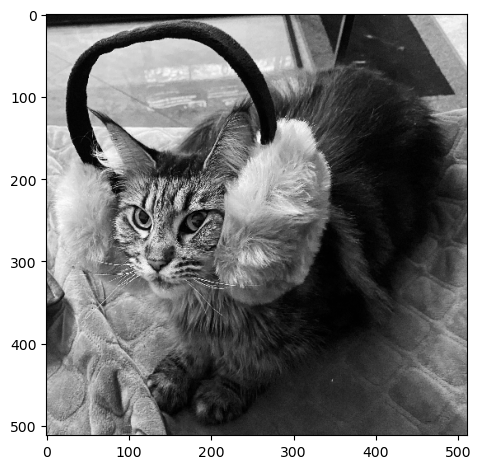

In [286]:
plt.imshow(gray_image, cmap="gray")

plt.tight_layout()

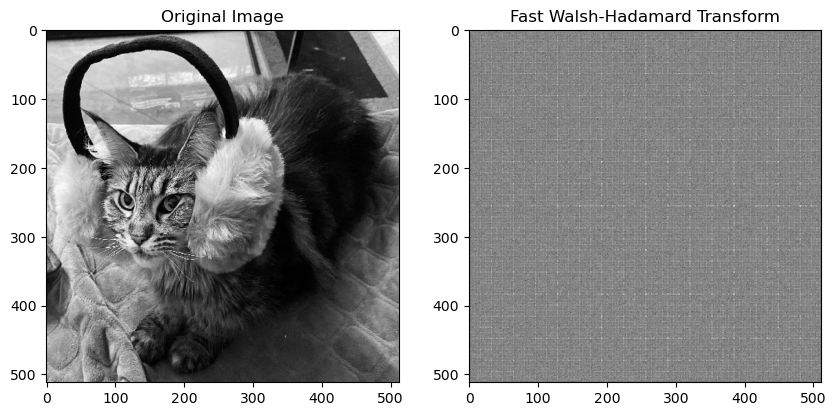

In [287]:
# Ensure the image has dimensions that are powers of 2 for the FWHT
new_rows, new_cols = gray_image.shape
# new_rows = int(2 ** np.ceil(np.log2(rows)))
# new_cols = int(2 ** np.ceil(np.log2(cols)))

# Resize the image if needed
resized_image = cv2.resize(gray_image, (new_cols, new_rows))

# Apply 2D Fast Walsh-Hadamard Transform
fwht_image = np.zeros_like(resized_image, dtype=np.float32)

# Apply 1D FWHT along rows
for i in range(new_rows):
    fwht_image[i, :] = np.array(fwht(resized_image[i, :])).astype(np.float32)

# Apply 1D FWHT along columns
for j in range(new_cols):
    fwht_image[:, j] = np.array(fwht(fwht_image[:, j])).astype(np.float32)

# Display the original and FWHT-transformed images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(gray_image, cmap='gray'), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(np.abs(fwht_image), cmap='gray', norm=LogNorm(1)), plt.title('Fast Walsh-Hadamard Transform')

plt.show()

In [378]:
def apply_low_pass_filter(freq, cutoff):
    rows, cols = freq.shape
    center = (rows // 2, cols // 2)
    # center = (0, 0)

    mask = np.zeros((rows, cols), dtype=np.uint8)
    r = int(cutoff * min(rows, cols))
    cv2.circle(mask, center, r, 1, -1)

    freq_low_pass = freq * mask
    freq_low_pass[mask == 0] = 1

    return freq_low_pass


def apply_high_pass_filter(freq, cutoff):
    rows, cols = freq.shape
    center = (rows // 2, cols // 2)
    # center = (0, 0)

    mask = np.ones((rows, cols), dtype=np.uint8)
    r = int(cutoff * min(rows, cols))
    cv2.circle(mask, center, r, 0, -1)

    freq_high_pass = freq * mask
    freq_high_pass[mask == 0] = 1

    return freq_high_pass


def apply_band_pass_filter(freq, low_cutoff, high_cutoff):
    rows, cols = freq.shape
    center = (rows // 2, cols // 2)
    # center = (0, 0)

    mask_high = np.zeros((rows, cols), dtype=np.uint8)
    r_high = int(high_cutoff * min(rows, cols))
    cv2.circle(mask_high, center, r_high, 1, -1)

    mask_low = np.ones((rows, cols), dtype=np.uint8)
    r_low = int(low_cutoff * min(rows, cols))
    cv2.circle(mask_low, center, r_low, 0, -1)

    mask = mask_low * mask_high
    freq_band_pass = freq * mask
    freq_band_pass[mask == 0] = 1

    return freq_band_pass


def apply_band_stop_filter(freq, low_cutoff, high_cutoff):
    rows, cols = freq.shape
    center = (rows // 2, cols // 2)
    # center = (0, 0)

    # band pass mask
    mask_high = np.zeros((rows, cols), dtype=np.uint8)
    r_high = int(high_cutoff * min(rows, cols))
    cv2.circle(mask_high, center, r_high, 1, -1)

    mask_low = np.ones((rows, cols), dtype=np.uint8)
    r_low = int(low_cutoff * min(rows, cols))
    cv2.circle(mask_low, center, r_low, 0, -1)

    # invert band pass to band stop mask
    mask = 1 - mask_low * mask_high
    freq_band_stop = freq * mask
    freq_band_stop[mask == 0] = 1

    return freq_band_stop

In [315]:
mmm = int(0.001 * np.max(fwht_image))
mmm

24762

(<Axes: title={'center': 'Fast Walsh-Hadamard Transform'}>,
 Text(0.5, 1.0, 'Fast Walsh-Hadamard Transform'))

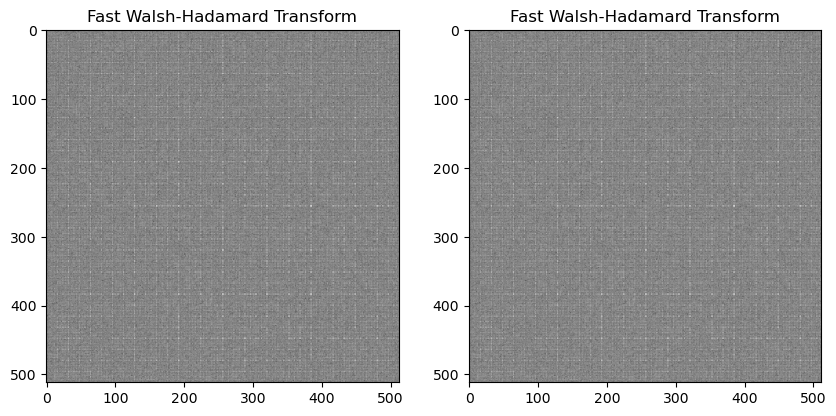

In [392]:
plt.figure(figsize=(10, 5))

# blur = cv2.GaussianBlur(fwht_image, (3, 3), 0)
# blur = cv2.bilateralFilter(fwht_image, 70, 500, 1000)
# blur = cv2.medianBlur(fwht_image, 3)


# kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# blur = cv2.filter2D(fwht_image, -1, kernel)

# blur = fwht_image - 0.5 * blur

# blur = apply_high_pass_filter(fwht_image, 0.2)
# blur = apply_low_pass_filter(fwht_image, 0.2)
# blur = apply_high_pass_filter(fwht_image, 0.5)

blur = fwht_image.copy()
# cv2.line(blur, (0, 256), (512, 256), (mmm, mmm, mmm), 1, 1)

# threshold = 0.005 * np.max(np.abs(blur))
# threshold = 0.0005 * np.max(np.abs(blur))
threshold = 0.00001 * np.max(np.abs(blur))
blur = np.where(np.abs(blur) > threshold, blur, 0.01)


# threshold = 0.001 * np.max(np.abs(blur))
# threshold = 0.003 * np.max(np.abs(blur))
# blur = np.where(np.abs(blur) < threshold, blur, 1)

plt.subplot(1, 2, 1), plt.imshow(np.abs(fwht_image), cmap='gray', norm=LogNorm(1)), plt.title('Fast Walsh-Hadamard Transform')

plt.subplot(1, 2, 2), plt.imshow(np.abs(blur), cmap='gray', norm=LogNorm(1)), plt.title('Fast Walsh-Hadamard Transform')

# fwht_image = blur

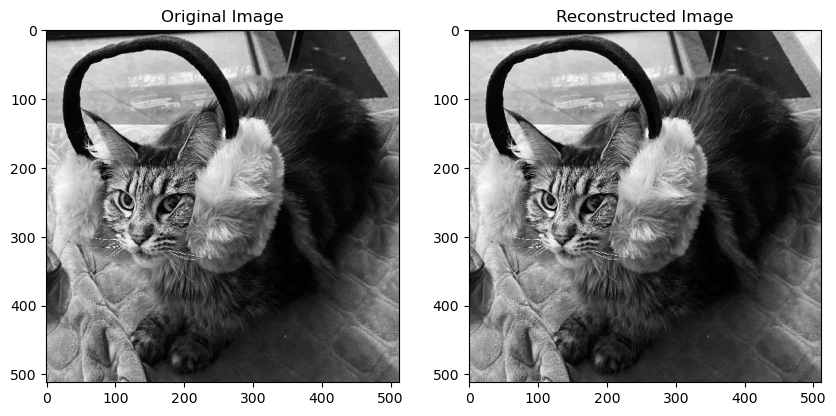

In [393]:
reconstructed = np.zeros_like(resized_image, dtype=np.float32)

# Apply 1D IFWHT along columns
for j in range(new_cols):
    reconstructed[:, j] = np.array(ifwht(blur[:, j])).astype(np.float32)

# Apply 1D IFWHT along rows
for i in range(new_rows):
    reconstructed[i, :] = np.array(ifwht(reconstructed[i, :])).astype(np.float32)

# Display the reconstructed image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1), plt.imshow(gray_image, cmap='gray'), plt.title('Original Image')
plt.subplot(1, 2, 2), plt.imshow(reconstructed, cmap='gray'), plt.title('Reconstructed Image')

plt.show()